In [29]:
import zipfile
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB3, InceptionV3, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers


In [30]:
extract_dir = './DATA'

In [31]:

# List contents to verify
print(os.listdir(extract_dir))
train_dir = os.path.join(extract_dir, 'train')
test_dir = os.path.join(extract_dir, 'testing')
train_csv_file_path = os.path.join(train_dir, 'train.csv')
test_csv_file_path = os.path.join(test_dir, 'testing.csv')

print(os.listdir(train_dir))
print(os.listdir(test_dir))
train_metadata = pd.read_csv(train_csv_file_path)
test_metadata = pd.read_csv(test_csv_file_path)

print(train_metadata.head())
print(test_metadata.head())
print(train_metadata.shape)
print(test_metadata.shape)

['testing', 'train']
['Acne', 'Actinic Keratosis', 'Basal Cell Carcinoma', 'Eczemaa', 'Normal', 'Rosacea', 'train.csv']
['Acne', 'Actinic Keratosis', 'Basal Cell Carcinoma', 'Eczemaa', 'Normal', 'Rosacea', 'testing.csv']
                  File Name Disease Name   
0     07AcnePittedScars.jpg         Acne  \
1              033007HB.jpg         Acne   
2              033073HB.jpg        Acne    
3  acne-closed-comedo-1.jpg        Acne    
4  acne-closed-comedo-2.jpg        Acne    

                                         Description   
0  A common skin condition characterized by pimpl...  \
1  A common skin condition characterized by pimpl...   
2  These are also known as a whitehead, is a non-...   
3  These are also known as a whitehead, is a non-...   
4  These are also known as a whitehead, is a non-...   

                                 Self care treatment  
0  To keep your pores from clogging and your skin...  
1  To keep your pores from clogging and your skin...  
2  To keep y

In [32]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255,
    validation_split=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)
# Create Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

NUM_CLASSES = len(train_generator.class_indices)  # Number of classes in the training set

# Shared input layer
shared_input = Input(shape=(224, 224, 3))



Found 419 images belonging to 6 classes.


Found 101 images belonging to 6 classes.
Found 216 images belonging to 6 classes.


In [33]:
def build_model(base_model, fine_tune_at=-1, l2_strength=0.01):
    base = base_model(weights='imagenet', include_top=False, input_tensor=shared_input)

    # Freeze layers up to the last fine_tune_at layers
    for layer in base.layers[:fine_tune_at]:
        layer.trainable = False
    for layer in base.layers[fine_tune_at:]:
        layer.trainable = True

    x = GlobalAveragePooling2D()(base.output)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_strength))(x) # L2 regularization
    x = Dropout(0.5)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax', kernel_regularizer=regularizers.l2(l2_strength))(x) # L2 regularization
    model = Model(inputs=shared_input, outputs=outputs)
    return model


# Build individual models with shared input and fine-tuning different layers
efficientnet_model = build_model(EfficientNetB3, fine_tune_at=-20)  # Fine-tune from the last 20 layers
densenet_model = build_model(DenseNet121, fine_tune_at=-15)  # Fine-tune from the last 15 layers
inceptionnet_model = build_model(InceptionV3, fine_tune_at=-10)  # Fine-tune from the last 10 layers


# Compile individual models
efficientnet_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
densenet_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
inceptionnet_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import numpy as np

class CustomModelCheckpoint(Callback):
    def __init__(self, filepath, monitor='val_loss', verbose=0, save_best_only=False, mode='auto', save_weights_only=False):
        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.verbose = verbose
        self.save_best_only = save_best_only
        self.save_weights_only = save_weights_only
        if mode not in ['auto', 'min', 'max']:
            mode = 'auto'
        if mode == 'min':
            self.monitor_op = np.less
            self.best = float('inf')
        elif mode == 'max':
            self.monitor_op = np.greater
            self.best = -float('inf')
        else:
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                self.monitor_op = np.greater
                self.best = -float('inf')
            else:
                self.monitor_op = np.less
                self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            return

        if self.save_best_only:
            if self.monitor_op(current, self.best) and not np.isnan(current):
                if self.verbose > 0:
                    print(f'\nEpoch {epoch+1}: {self.monitor} improved from {self.best} to {current}, saving model to {self.filepath}')
                self.best = current
                if self.save_weights_only:
                    self.model.save_weights(self.filepath, overwrite=True)
                else:
                    self.model.save(self.filepath, overwrite=True)
        else:
            if self.verbose > 0:
                print(f'\nEpoch {epoch+1}: saving model to {self.filepath}')
            if self.save_weights_only:
                self.model.save_weights(self.filepath, overwrite=True)
            else:
                self.model.save(self.filepath, overwrite=True)



callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath='weights/best_weights.h5', save_best_only=True, monitor='val_loss', save_weights_only=True)
]


In [34]:
efficientnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
14/14 [==============================] - 21s 1s/step - loss: 5.8194 - accuracy: 0.1718 - val_loss: 5.1766 - val_accuracy: 0.1683
Epoch 2/20
14/14 [==============================] - 15s 1s/step - loss: 4.7614 - accuracy: 0.1885 - val_loss: 4.3119 - val_accuracy: 0.1683
Epoch 3/20
14/14 [==============================] - 15s 1s/step - loss: 3.9118 - accuracy: 0.1981 - val_loss: 3.6607 - val_accuracy: 0.1386
Epoch 4/20
14/14 [==============================] - 15s 1s/step - loss: 3.3134 - accuracy: 0.1718 - val_loss: 3.1131 - val_accuracy: 0.2178
Epoch 5/20
14/14 [==============================] - 15s 1s/step - loss: 2.9041 - accuracy: 0.2220 - val_loss: 2.7733 - val_accuracy: 0.1584
Epoch 6/20
14/14 [==============================] - 17s 1s/step - loss: 2.6488 - accuracy: 0.1862 - val_loss: 2.5051 - val_accuracy: 0.1584
Epoch 7/20
14/14 [==============================] - 18s 1s/step - loss: 2.4001 - accuracy: 0.2315 - val_loss: 2.3218 - val_accuracy: 0.1584
Epoch 8/20
14/14 [==

In [35]:
densenet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
14/14 [==============================] - 19s 1s/step - loss: 5.4074 - accuracy: 0.3317 - val_loss: 4.8363 - val_accuracy: 0.4455
Epoch 2/20
14/14 [==============================] - 15s 1s/step - loss: 3.8719 - accuracy: 0.5823 - val_loss: 3.6811 - val_accuracy: 0.5941
Epoch 3/20
14/14 [==============================] - 14s 1s/step - loss: 3.1652 - accuracy: 0.6563 - val_loss: 3.6717 - val_accuracy: 0.5050
Epoch 4/20
14/14 [==============================] - 14s 1s/step - loss: 2.6095 - accuracy: 0.7088 - val_loss: 3.1540 - val_accuracy: 0.5644
Epoch 5/20
14/14 [==============================] - 14s 1s/step - loss: 2.3775 - accuracy: 0.7279 - val_loss: 2.6643 - val_accuracy: 0.6139
Epoch 6/20
14/14 [==============================] - 15s 1s/step - loss: 2.1418 - accuracy: 0.7685 - val_loss: 2.7683 - val_accuracy: 0.5941
Epoch 7/20
14/14 [==============================] - 15s 1s/step - loss: 1.9576 - accuracy: 0.7947 - val_loss: 2.2653 - val_accuracy: 0.7030
Epoch 8/20
14/14 [==

In [36]:

inceptionnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20
14/14 [==============================] - 10s 582ms/step - loss: 6.9245 - accuracy: 0.3007 - val_loss: 5.9157 - val_accuracy: 0.4950
Epoch 2/20
14/14 [==============================] - 7s 482ms/step - loss: 5.3838 - accuracy: 0.4869 - val_loss: 4.9972 - val_accuracy: 0.4554
Epoch 3/20
14/14 [==============================] - 7s 482ms/step - loss: 4.7056 - accuracy: 0.5179 - val_loss: 4.4902 - val_accuracy: 0.5446
Epoch 4/20
14/14 [==============================] - 7s 486ms/step - loss: 4.2077 - accuracy: 0.5585 - val_loss: 4.0162 - val_accuracy: 0.5743
Epoch 5/20
14/14 [==============================] - 7s 489ms/step - loss: 3.7274 - accuracy: 0.6539 - val_loss: 3.7264 - val_accuracy: 0.5248
Epoch 6/20
14/14 [==============================] - 7s 499ms/step - loss: 3.4496 - accuracy: 0.6611 - val_loss: 3.4159 - val_accuracy: 0.5842
Epoch 7/20
14/14 [==============================] - 7s 540ms/step - loss: 3.2633 - accuracy: 0.6325 - val_loss: 3.2208 - val_accuracy: 0.6040
Epoch

In [37]:

# Save individual model weights
efficientnet_model.save_weights('weights/efficientnet_model_finetuned_weights.h5')
densenet_model.save_weights('weights/densenet_model_finetuned_weights.h5')
inceptionnet_model.save_weights('weights/inceptionnet_model_finetuned_weights.h5')

In [44]:
# Build ensemble model
def build_ensemble(models, shared_input): # Add shared_input as argument
    outputs = [model.output for model in models]
    x = tf.keras.layers.Average()(outputs)
    ensemble_model = Model(inputs=shared_input, outputs=x) # Use shared_input here
    return ensemble_model

ensemble_model = build_ensemble([efficientnet_model, densenet_model, inceptionnet_model], shared_input)

# Compile ensemble model
ensemble_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Evaluate ensemble model
ensemble_model.evaluate(validation_generator)

# Save ensemble model weights
ensemble_model.save_weights('weights/ensemble_model_finetuned_weights.h5')



4/4 [==============================] - 11s 1s/step - loss: 3.0251 - accuracy: 0.6832


In [45]:
# Rebuild the model architectures
def build_model(base_model, fine_tune_at=-1, l2_strength=0.01):
    base = base_model(weights='imagenet', include_top=False, input_tensor=shared_input)

    # Freeze layers up to the last fine_tune_at layers
    for layer in base.layers[:fine_tune_at]:
        layer.trainable = False
    for layer in base.layers[fine_tune_at:]:
        layer.trainable = True

    x = GlobalAveragePooling2D()(base.output)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_strength))(x) # L2 regularization
    x = Dropout(0.5)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax', kernel_regularizer=regularizers.l2(l2_strength))(x) # L2 regularization
    model = Model(inputs=shared_input, outputs=outputs)
    return model

# Rebuild the base models
efficientnet_model_rebuilt = build_model(EfficientNetB3, fine_tune_at=-20)
densenet_model_rebuilt = build_model(DenseNet121, fine_tune_at=-15)
inceptionnet_model_rebuilt = build_model(InceptionV3, fine_tune_at=-10)

# Load the saved weights into the base models
efficientnet_model_rebuilt.load_weights('weights/efficientnet_model_finetuned_weights.h5')
densenet_model_rebuilt.load_weights('weights/densenet_model_finetuned_weights.h5')
inceptionnet_model_rebuilt.load_weights('weights/inceptionnet_model_finetuned_weights.h5')


In [46]:
# Rebuild the ensemble model
ensemble_model_rebuilt = build_ensemble([efficientnet_model_rebuilt, densenet_model_rebuilt, inceptionnet_model_rebuilt], shared_input)

# Compile the rebuilt ensemble model
ensemble_model_rebuilt.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Save the ensemble model weights
ensemble_model_rebuilt.save_weights('weights/ensemble_model_finetuned_rebuilt_weights.h5')


In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import pandas as pd

# Function to get disease info
def get_disease_info(metadata, disease_class):
    info = metadata[metadata['Disease Name'] == disease_class]
    description = info['Description'].values[0]
    self_care = info['Self care treatment'].values[0]
    return description, self_care

# Function to classify and get info
def classify_and_get_info(image, models, metadata):
    img_array = img_to_array(image) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = [model.predict(img_array) for model in models]
    avg_predictions = np.mean(predictions, axis=0)
    predicted_class_idx = np.argmax(avg_predictions)
    predicted_class = list(validation_generator.class_indices.keys())[predicted_class_idx]

    description, self_care = get_disease_info(metadata, predicted_class)
    return predicted_class, description, self_care

# OpenCV to capture image from webcam
def capture_and_classify(models, metadata):
    cap = cv2.VideoCapture(0)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Preprocess the frame
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))

        # Classify and get info
        predicted_class, description, self_care = classify_and_get_info(img, models, metadata)

        # Display the results
        cv2.putText(frame, f"Class: {predicted_class}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.putText(frame, f"Description: {description}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.putText(frame, f"Self Care: {self_care}", (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)

        cv2.imshow('Skin Disease Detection', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    try:
        cv2.destroyAllWindows()
    except:
        pass

# Function to classify an image file
def classify_image_file(image_path, models, metadata):
    img = load_img(image_path, target_size=(224, 224))
    predicted_class, description, self_care = classify_and_get_info(img, models, metadata)
    print(f"Predicted Class: {predicted_class}")
    print(f"Description: {description}")
    print(f"Self Care: {self_care}")

    # Display the image with predictions
    plt.imshow(img)
    plt.title(f"Class: {predicted_class}\nDescription: {description}\nSelf Care: {self_care}")
    plt.axis('off')
    plt.show()

# Load test metadata
test_metadata = pd.read_csv(test_csv_file_path)

# Rebuild the base models and load the weights
efficientnet_model_rebuilt = build_model(EfficientNetB3, fine_tune_at=-20)
densenet_model_rebuilt = build_model(DenseNet121, fine_tune_at=-15)
inceptionnet_model_rebuilt = build_model(InceptionV3, fine_tune_at=-10)

efficientnet_model_rebuilt.load_weights('weights/efficientnet_model_finetuned_weights.h5')
densenet_model_rebuilt.load_weights('weights/densenet_model_finetuned_weights.h5')
inceptionnet_model_rebuilt.load_weights('weights/inceptionnet_model_finetuned_weights.h5')


1/1 [==============================] - 0s 59ms/step
Predicted Class: Acne
Description: A common skin condition characterized by pimples, blackheads, and whiteheads resulting from clogged pores and inflammation.
Self Care: To keep your pores from clogging and your skin from becoming too oily:

1. Clean your skin gently with a mild, non-drying soap.
2. It may help to use a wash with salicylic acid or benzoyl if your skin is oily and prone to acne. Remove all dirt or make up.
3. Wash once or twice a day, and also after exercising. Avoid scrubbing or repeated, frequent skin washing.
4. Shampoo your hair daily, if it is oily.
5. Comb or pull your hair back to keep the hair out of your face.
6. Avoid using rubbing alcohol or toners that are very drying to the skin.
7. Avoid oil-based cosmetics.


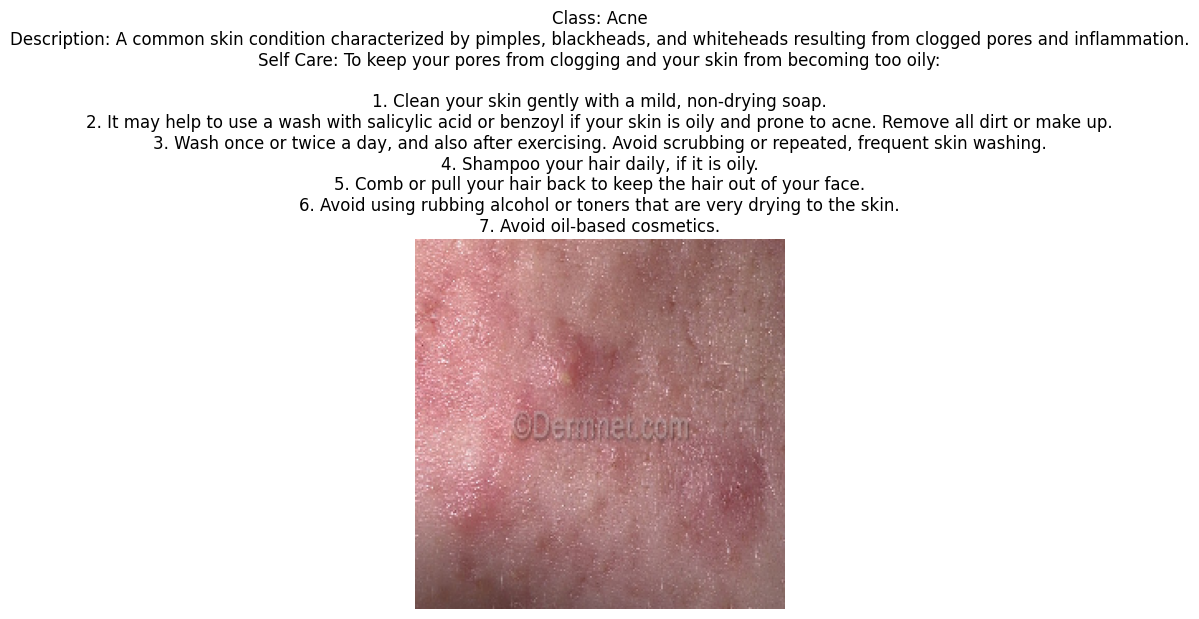

In [59]:

# Example usage
image_path = r'DATA/testing/Acne/07AcnePittedScars1.jpg'
classify_image_file(image_path, [efficientnet_model_rebuilt, densenet_model_rebuilt, inceptionnet_model_rebuilt], test_metadata)
# capture_and_classify([efficientnet_model_rebuilt, densenet_model_rebuilt, inceptionnet_model_rebuilt], test_metadata)
